# Facemask Image Classifier

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/raihanastrada/facemask-image-classifier/blob/main/facemask_image_classifier.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import zipfile
import random
from shutil import copyfile, rmtree

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

try:
  import kaggle
except:
  !pip install kaggle

In [ ]:
PATH_TO_KAGGLE = # Fill this with path to kaggle.json on your Google Drive

In [ ]:
!mkdir ~/.kaggle

copyfile(PATH_TO_KAGGLE, '/root/.kaggle/kaggle.json')

!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download pranavsingaraju/facemask-detection-dataset-20000-images

local_zip = './facemask-detection-dataset-20000-images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')

zip_ref.close()

 96% 579M/604M [00:19<00:00, 26.8MB/s]
100% 604M/604M [00:19<00:00, 32.2MB/s]


In [ ]:
source_path_mask = '/tmp/new_with_mask'
source_path_no_mask = '/tmp/new_without_mask'

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_mask))} images of facemask.")
print(f"There are {len(os.listdir(source_path_no_mask))} images of no facemask.")

There are 10000 images of facemask.
There are 10000 images of no facemask.


In [ ]:
# Define root directory
root_dir = '/tmp/mask-nomask'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  rmtree(root_dir)

def create_train_test_dirs(root_path):
  train_dir = os.path.join(root_path, 'training')
  test_dir = os.path.join(root_path, 'testing')

  train_mask_dir = os.path.join(train_dir, 'mask')
  test_mask_dir = os.path.join(test_dir, 'mask')

  train_no_mask_dir = os.path.join(train_dir, 'no mask')
  test_no_mask_dir = os.path.join(test_dir, 'no mask')

  dirs = [train_dir, test_dir, 
          train_mask_dir, test_mask_dir, 
          train_no_mask_dir, test_no_mask_dir]

  for dir in dirs:
    os.makedirs(dir)
  
try:
  create_train_test_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/mask-nomask/training
/tmp/mask-nomask/testing
/tmp/mask-nomask/training/no mask
/tmp/mask-nomask/training/mask
/tmp/mask-nomask/testing/no mask
/tmp/mask-nomask/testing/mask


In [ ]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  # Get list of contents on the directory
  files = []

  for filename in os.listdir(SOURCE):
    file_path = os.path.join(SOURCE, filename)
    if (os.path.getsize(file_path) > 0):
      files.append(filename)
    else:
      print(filename + " is zero length, so ignoring.")

  filecount = len(files)
  train_size = int(filecount * SPLIT_SIZE)
  test_size = int(filecount - train_size)

  # Shuffle
  shuffled_files = random.sample(files, filecount)
  train_list = shuffled_files[0:train_size]
  test_list = shuffled_files[-test_size:]

  for filename in train_list:
    copyfile(os.path.join(SOURCE, filename), 
             os.path.join(TRAINING, filename))
  for filename in test_list:
    copyfile(os.path.join(SOURCE, filename), 
             os.path.join(TESTING, filename))


In [ ]:
# Define paths
MASK_SOURCE_DIR = source_path_mask
NO_MASK_SOURCE_DIR = source_path_no_mask

TRAINING_DIR = "/tmp/mask-nomask/training/"
TESTING_DIR = "/tmp/mask-nomask/testing/"

TRAINING_MASK_DIR = os.path.join(TRAINING_DIR, "mask/")
TESTING_MASK_DIR = os.path.join(TESTING_DIR, "mask/")

TRAINING_NO_MASK_DIR = os.path.join(TRAINING_DIR, "no mask/")
TESTING_NO_MASK_DIR = os.path.join(TESTING_DIR, "no mask/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_MASK_DIR)) > 0:
  for file in os.scandir(TRAINING_MASK_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_NO_MASK_DIR)) > 0:
  for file in os.scandir(TRAINING_NO_MASK_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_MASK_DIR)) > 0:
  for file in os.scandir(TESTING_MASK_DIR):
    os.remove(file.path)
if len(os.listdir(TESTING_NO_MASK_DIR)) > 0:
  for file in os.scandir(TESTING_NO_MASK_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(MASK_SOURCE_DIR, TRAINING_MASK_DIR, TESTING_MASK_DIR, split_size)
split_data(NO_MASK_SOURCE_DIR, TRAINING_NO_MASK_DIR, TESTING_NO_MASK_DIR, split_size)

# Check that the number of images matches the expected output
print(f"\n\nThere are {len(os.listdir(TRAINING_MASK_DIR))} images of facemask for training")
print(f"There are {len(os.listdir(TRAINING_NO_MASK_DIR))} images of no facemask for training")
print(f"There are {len(os.listdir(TESTING_MASK_DIR))} images of facemask for testing")
print(f"There are {len(os.listdir(TESTING_NO_MASK_DIR))} images of no facemask for testing")



There are 9000 images of facemask for training
There are 9000 images of no facemask for training
There are 1000 images of facemask for testing
There are 1000 images of no facemask for testing


In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                     rotation_range = 45,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     brightness_range = [0.2,0.2],
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64,
                                                      class_mode='binary',
                                                      color_mode='grayscale',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=64,
                                                                class_mode='binary',
                                                                color_mode='grayscale',
                                                                target_size=(150, 150))
  return train_generator, validation_generator


In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.optimizers import RMSprop

def create_model():
  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('mask') and 1 for the other ('no mask')
    tf.keras.layers.Dense(1, activation='sigmoid')  
  ])

  
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])     

  return model


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    # Check validation accuracy
    if(logs.get('accuracy') >= 0.975):
      # Stop if threshold is met
      print("\nAccuracy is higher or equal than 97.5% so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
# Get the untrained model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    epochs=5,
                    verbose=1,
                    validation_data=validation_generator,
                    )

Epoch 1/5
282/282 [==============================] - 69s 239ms/step - loss: 0.3444 - accuracy: 0.8509 - val_loss: 1.5619 - val_accuracy: 0.9160
Epoch 2/5
282/282 [==============================] - 65s 231ms/step - loss: 0.1373 - accuracy: 0.9525 - val_loss: 2.2517 - val_accuracy: 0.8625
Epoch 3/5
282/282 [==============================] - 67s 237ms/step - loss: 0.0896 - accuracy: 0.9696 - val_loss: 1.2950 - val_accuracy: 0.9325
Epoch 4/5
282/282 [==============================] - 65s 232ms/step - loss: 0.0525 - accuracy: 0.9818 - val_loss: 6.3259 - val_accuracy: 0.7950
Epoch 5/5
282/282 [==============================] - 67s 238ms/step - loss: 0.0531 - accuracy: 0.9842 - val_loss: 0.5586 - val_accuracy: 0.9725


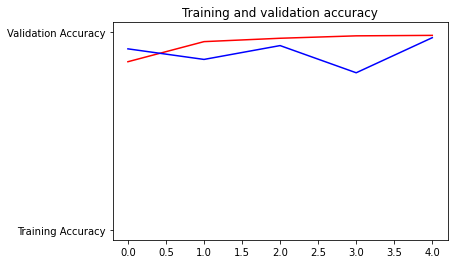

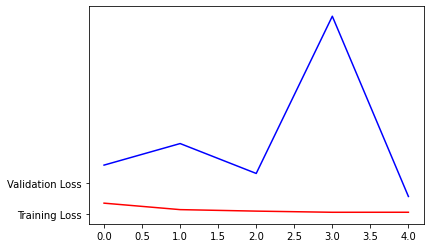

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
def visualize(original, title):
  plt.imshow(original)
  plt.axis('off')
  plt.title(title)

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded=files.upload()

Saving Mask66.jpg to Mask66.jpg
Saving Mask90.jpeg to Mask90.jpeg
Saving Mask157.jpg to Mask157.jpg
Saving Mask175.jpg to Mask175.jpg
Saving Mask275.jpg to Mask275.jpg
Saving No Mask10.jpg to No Mask10.jpg
Saving No Mask100.jpg to No Mask100.jpg
Saving No Mask106.jpg to No Mask106.jpg
Saving No Mask107.jpg to No Mask107.jpg


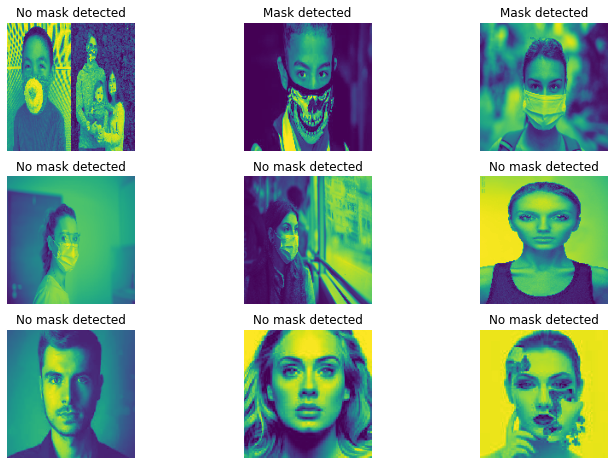

In [ ]:
# create figure
fig = plt.figure(figsize=(12, 8))
  
# setting values to rows and column variables
rows = 3
columns = 3

for i, fn in enumerate(uploaded.keys()):
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(150, 150), grayscale=True)
  
  x=image.img_to_array(img)
  x/=255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
    
  if classes[0]>0.5:
    title = ("No mask detected")
  else:
    title = ("Mask detected")

  # Visualize
  fig.add_subplot(rows, columns, i+1)
  visualize(img, title,)
 